# Bolometric corrections

**Depreciated** in favour of using `isoclassify`.

This notebook also explores the effects of input parameters on the BCs and finds the dominant is effective temperature such that increasing effective temperature decreases BC for a given metallicity (ASPCAP SDSS DR13), k-band photometry (2MASS) and extinction (Berger et al. 2018).

In [1]:
import numpy as np
import pandas as pd
import pymc3 as pm
from isochrones.mist.bc import MISTBolometricCorrectionGrid
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm_notebook as tqdm

Holoviews not imported. Some visualizations will not be available.
PyMultiNest not imported.  MultiNest fits will not work.


In [2]:
path = '../data/archive/s17-b18-gaia-2mass_seis.csv'

df = pd.read_csv(path)
df.head()

,KIC,numax,enumax,Dnu,eDnu,Length,HBR,Teff_SDSS,eTeff_SDSS,[M/H]_SDSS,...,Qflg,Rflg,Bflg,Cflg,Xflg,Aflg,seis_logg_SDSS,seis_logg_err_SDSS,seis_logg_ASPC,seis_logg_err_ASPC
0,1435467,1382.311,19.038,70.558,0.087,938.1,1.662,6433.0,86.0,-0.028,...,b'AAA',b'111',b'111',b'000',0,0,4.111703,0.007873,4.100044,0.007723
1,2010607,674.919,146.523,42.479,2.185,28.9,1.547,6361.0,71.0,-0.070,...,b'AAA',b'222',b'111',b'000',0,0,3.797905,0.094409,3.785706,0.094411
2,2309595,643.208,11.226,39.029,0.721,28.9,1.767,5238.0,65.0,-0.095,...,b'AAA',b'222',b'111',b'000',0,0,3.734825,0.009083,3.724735,0.009181
3,2450729,1053.105,114.904,61.910,2.539,28.9,1.470,6029.0,59.0,-0.212,...,b'AAA',b'222',b'111',b'000',0,0,3.979485,0.047620,3.972583,0.047643
4,2837475,1629.761,18.396,75.720,0.129,1029.4,1.767,6688.0,57.0,-0.015,...,b'AAA',b'111',b'111',b'000',0,0,4.191662,0.006726,4.179901,0.006888


Berger used 0.04 mag uncertainty in Av

In [3]:
df['eAV'] = 0.04
df.head()

,KIC,numax,enumax,Dnu,eDnu,Length,HBR,Teff_SDSS,eTeff_SDSS,[M/H]_SDSS,...,Rflg,Bflg,Cflg,Xflg,Aflg,seis_logg_SDSS,seis_logg_err_SDSS,seis_logg_ASPC,seis_logg_err_ASPC,eAV
0,1435467,1382.311,19.038,70.558,0.087,938.1,1.662,6433.0,86.0,-0.028,...,b'111',b'111',b'000',0,0,4.111703,0.007873,4.100044,0.007723,0.04
1,2010607,674.919,146.523,42.479,2.185,28.9,1.547,6361.0,71.0,-0.070,...,b'222',b'111',b'000',0,0,3.797905,0.094409,3.785706,0.094411,0.04
2,2309595,643.208,11.226,39.029,0.721,28.9,1.767,5238.0,65.0,-0.095,...,b'222',b'111',b'000',0,0,3.734825,0.009083,3.724735,0.009181,0.04
3,2450729,1053.105,114.904,61.910,2.539,28.9,1.470,6029.0,59.0,-0.212,...,b'222',b'111',b'000',0,0,3.979485,0.047620,3.972583,0.047643,0.04
4,2837475,1629.761,18.396,75.720,0.129,1029.4,1.767,6688.0,57.0,-0.015,...,b'111',b'111',b'000',0,0,4.191662,0.006726,4.179901,0.006888,0.04


In [43]:
scale = 'ASPC'

In [60]:
# teff_obs = df[[f'Teff_{scale}', f'eTeff_{scale}']].to_numpy()
teff_obs = df[[f'Teff', f'e_Teff']].to_numpy()  # B18
logg_obs = df[[f'seis_logg_{scale}', f'seis_logg_err_{scale}']].to_numpy()
feh_obs = df[[f'[M/H]_{scale}', f'e[M/H]_{scale}']].to_numpy()
av_obs = df[[f'AV', f'eAV']].to_numpy()

In [72]:
logg_obs[:, 0] += 0.1

In [73]:
bc_grid = MISTBolometricCorrectionGrid(['J', 'H', 'K', 'G', 'BP', 'RP'])

In [74]:
n = len(df)
print(n)

394


In [75]:
n_samples = 1000

teff = np.random.normal(*teff_obs.T, size=(n_samples, n))
logg = np.random.normal(*logg_obs.T, size=(n_samples, n))
feh = np.random.normal(*feh_obs.T, size=(n_samples, n))
av = np.random.normal(*av_obs.T, size=(n_samples, n))

In [76]:
bands = ['K', 'G']

samples = np.zeros((n, len(bands), n_samples))
for i, (t, g, f, a) in tqdm(enumerate(zip(teff, logg, feh, av)), total=n_samples):
    samples[:, :, i] = bc_grid.interp([t, g, f, a], bands)

In [77]:
bc = {}
summary = {}
for i, band in enumerate(bands):
    bc[band] = pd.DataFrame(samples[:, i, :].T)
    summary[band] = bc[band].describe(percentiles=[0.16, .5, 0.84])

In [78]:
scale = 'B18+0.1g'

for band in bands:
    df[f'bc_{band}_{scale}'] = summary[band].loc['mean']
    df[f'bc_{band}_err_{scale}'] = summary[band].loc['std']

In [79]:
df.head()

,KIC,numax,enumax,Dnu,eDnu,Length,HBR,Teff_SDSS,eTeff_SDSS,[M/H]_SDSS,...,bc_G_B18,bc_G_err_B18,bc_K_B18+0.02g,bc_K_err_B18+0.02g,bc_G_B18+0.02g,bc_G_err_B18+0.02g,bc_K_B18+0.1g,bc_K_err_B18+0.1g,bc_G_B18+0.1g,bc_G_err_B18+0.1g
0,1435467,1382.311,19.038,70.558,0.087,938.1,1.662,6433.0,86.0,-0.028,...,0.055963,0.026125,1.154193,0.063054,0.053633,0.027963,1.155347,0.063943,0.054417,0.027141
1,2010607,674.919,146.523,42.479,2.185,28.9,1.547,6361.0,71.0,-0.070,...,-0.118618,0.036307,1.177792,0.064188,-0.121782,0.035394,1.179610,0.064069,-0.121155,0.034751
2,2309595,643.208,11.226,39.029,0.721,28.9,1.767,5238.0,65.0,-0.095,...,-0.103131,0.037832,1.786333,0.060952,-0.102141,0.037563,1.782546,0.063034,-0.102821,0.038893
3,2450729,1053.105,114.904,61.910,2.539,28.9,1.470,6029.0,59.0,-0.212,...,-0.072675,0.035943,1.373115,0.062064,-0.071321,0.035711,1.371944,0.062095,-0.073308,0.036079
4,2837475,1629.761,18.396,75.720,0.129,1029.4,1.767,6688.0,57.0,-0.015,...,0.042260,0.031417,1.013568,0.063930,0.043005,0.031125,1.014915,0.059901,0.040798,0.030704


In [85]:
df_spec = pd.read_csv('../data/spectroscopy/s17_gaia_4arcsec_apogeeDR14.csv')

(0.6, 2.0)

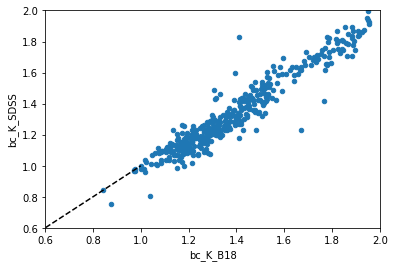

In [81]:
ax = df.plot(kind='scatter', x='bc_K_B18', y='bc_K_SDSS')
ax.plot([-1, 1], [-1, 1], 'k--')
ax.set_xlim(0.6, 2.)
ax.set_ylim(0.6, 2.)

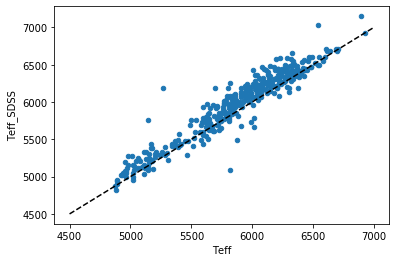

In [84]:
ax = df.plot(kind='scatter', x='Teff', y='Teff_SDSS')
ax.plot([4500, 7000], [4500, 7000], 'k--')
# ax.set_xlim(0.6, 2.)
# ax.set_ylim(0.6, 2.)

In [89]:
df_super = df.merge(df_spec[df_spec['nearest_neighbour']==1], left_on='KIC', right_on='kepid')

(4500, 7000)

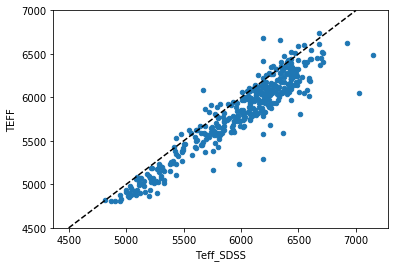

In [93]:
lim = [4500, 7000]
ax = df_super.plot(kind='scatter', x='Teff_SDSS', y='TEFF')
ax.plot(lim, lim, 'k--')
# ax.set_xlim(0.6, 2.)
ax.set_ylim(lim)

(4500, 7000)

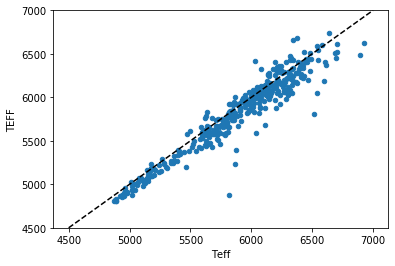

In [94]:
lim = [4500, 7000]
ax = df_super.plot(kind='scatter', x='Teff', y='TEFF')
ax.plot(lim, lim, 'k--')
# ax.set_xlim(0.6, 2.)
ax.set_ylim(lim)

APOGEE DR14 temperatures (TEFF) lower than both the SDSS griz and B18 scales -> we expect lower luminosities than both

In [152]:
df.to_csv('../data/archive/s17-b18-gaia-2mass_bc.csv', index=False)